In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import xarray as xr
import cftime
import utils.geo as geo
import gsw
import numpy as np
from dask.diagnostics import ProgressBar

In [18]:
rootdir = '/projects/SOCCOM/datasets/gobai-o2/'
filename = 'GOBAI-O2-v1.0'
ds = xr.open_dataset(rootdir+filename+'.nc',decode_times=False)
# Decode time coordinate
ds = ds.assign_coords({'time':cftime.num2date(ds['time'],units='days since 01-01-01')})
# Reconfigure longitude coordinate
ds['lon'] = ds['lon'].where(~((ds['lon']>20)&(ds['lon']<180)),ds['lon']-360)
# Chunk dataset
ds = ds.chunk({'time':12})

In [19]:
axes_dims_dict = {'X':'lon','Y':'lat'}
ds_new,xgrid = geo.get_xgcm_horizontal(ds,
                                       axes_dims_dict=axes_dims_dict,
                                       position=('center','left'),
                                       periodic='X')
retain = ['dxG','dyG','dxC','dyC','rC']
grid = ds_new[retain]

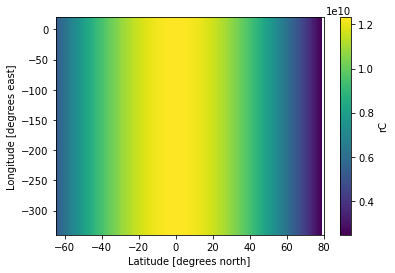

In [20]:
grid['rC'].plot()

In [21]:
p_l = ds['pres'].values
dp_last = np.diff(p_l)[-1]
p_l_exp = np.append(p_l,p_l[-1]+dp_last)
p_i = np.append(0,0.5*(p_l_exp[1:]+p_l_exp[:-1]))
grid['pres_i'] = xr.DataArray(p_i,dims=['pres_i'],coords={'pres_i':p_i})
grid['dp'] = xr.DataArray(np.diff(p_i),dims=['pres'],coords={'pres':p_l})

In [22]:
with ProgressBar():
    ds.to_zarr(rootdir+filename+'_processed.zarr',mode='w')
    grid.to_netcdf(rootdir+'regular_grid.nc',mode='w')

In [23]:
grid

<xarray.Dataset>
Dimensions:   (lon_left: 360, lat: 145, lon: 360, lat_left: 145, pres_i: 59,
               pres: 58)
Coordinates:
  * lon       (lon) float32 -339.5 -338.5 -337.5 -336.5 ... 16.5 17.5 18.5 19.5
  * lat       (lat) float32 -64.5 -63.5 -62.5 -61.5 ... 76.5 77.5 78.5 79.5
  * lon_left  (lon_left) float32 -340.0 -339.0 -338.0 -337.0 ... 17.0 18.0 19.0
  * lat_left  (lat_left) float32 -65.0 -64.0 -63.0 -62.0 ... 76.0 77.0 78.0 79.0
  * pres_i    (pres_i) float64 0.0 6.25 15.0 ... 1.85e+03 1.938e+03 2.012e+03
  * pres      (pres) float32 2.5 10.0 20.0 30.0 ... 1.8e+03 1.9e+03 1.975e+03
Data variables:
    dxG       (lon_left, lat) float32 4.779e+04 4.953e+04 ... 2.023e+04
    dyG       (lon, lat_left) float32 nan 1.11e+05 ... 1.11e+05 1.11e+05
    dxC       (lon, lat) float32 4.779e+04 4.953e+04 ... 2.213e+04 2.023e+04
    dyC       (lon, lat) float32 1.11e+05 1.11e+05 1.11e+05 ... 1.11e+05 nan
    rC        (lon, lat) float32 5.304e+09 5.498e+09 5.689e+09 ... 2.456e+09 nan
    dp        (pres) float64 6.25 8.75 10.0 10.0 10.0 ... 100.0 100.0 87.5 75.0